## Introduction

One of my favorite activities in mathematics is exploring simple rules that can create complex systems. [Fractals](http://mathworld.wolfram.com/Fractal.html), such as those generated by Lindemayer systems (L-systems), are a great example of this. They are simple enough that they can be explained in ten minutes, but you could easily spend hours exploring what they are capable of.

In this tutorial, I begin with line-drawing as a primitive and build up to a working L-system.

## Cartesian Plotting

To draw fractals, first we need to be able to draw lines. I'll use a library called [**matplotlib**](https://matplotlib.org/) to do the drawing. If you are already familiar with matplotlib, you can [skip to the next section](#Turtle-Graphics).

The following code loads matplotlib:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')  # Use some nicer default colors

Now we can use matplotlib to draw lines by calling `plt.plot`. We need to pass it two lists: a list of values on the x-axis, and a list of values on the y-axis. matplotlib steps through both of these lists at the same time to create coordinate pairs, and then draws a line through them.

For example, to draw a line from the point `(0, 0)` to `(1, 1)`, and then another line from `(1, 1)` to `(2, 0)`, we can make the following call to `plot`:

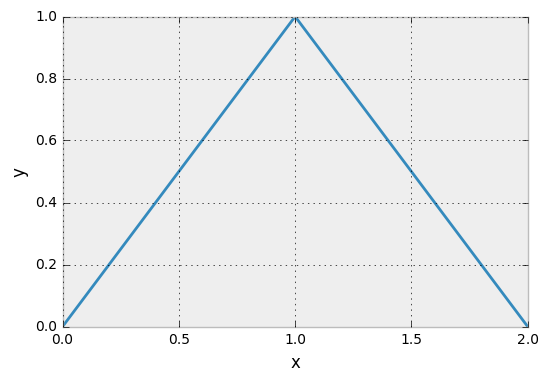

In [2]:
plt.plot(
    [0, 1, 2],  # X-values
    [0, 1, 0]   # Y-values
)
# The next two lines add labels to the axes.
plt.xlabel('x')
plt.ylabel('y');

I find it easier to think about lists of coordinate pairs than it is to think about two lists of coordinates. Below is a function below that takes a list of coordinates, converts them to the lists that matplotlib expects, and plots them.

In [3]:
def plot_coords(coords, bare_plot=False):
    if bare_plot:
        # Turns off the axis markers.
        plt.axis('off')
    # Ensures equal aspect ratio.
    plt.axes().set_aspect('equal', 'datalim')
    # Converts a list of coordinates into 
    # lists of X and Y values, respectively.
    X, Y = zip(*coords)
    # Draws the plot.
    plt.plot(X, Y);

Now we can draw a series of points with matplotlib like this:

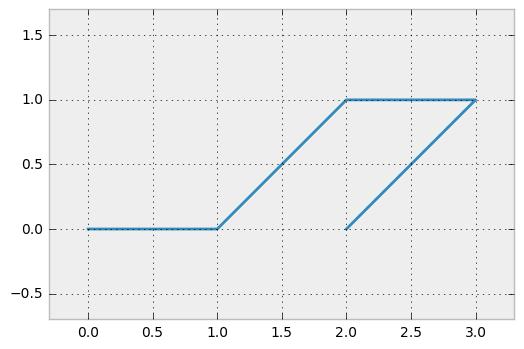

In [4]:
plot_coords([
    (0, 0),
    (1, 0),
    (2, 1),
    (3, 1),
    (2, 0)
])

If this is the first time you're encountering this approach to drawing, take a minute to figure out which corner of the shape corresponds to each point. Note that the origin `(0, 0)` is in the lower-left corner and coordinates count up (along the Y-axis) and to the right (along the X-axis). The coordinates are given as `(x, y)` pairs.

We can also draw lines that aren't connected by putting a pair of `nan` ("not a number") values in the list. For example:

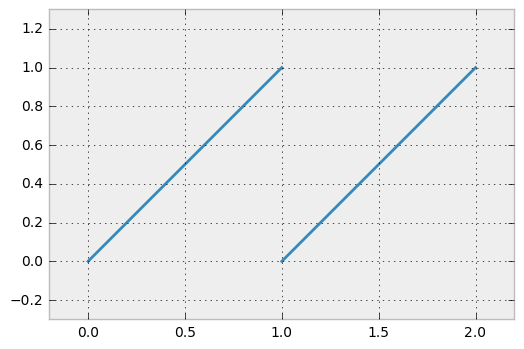

In [5]:
nan = float('nan')
plot_coords([
    (0, 0),
    (1, 1),
    (nan, nan),
    (1, 0),
    (2, 1)
])

## Turtle Graphics

So far we've drawn a shape by providing a list of points. Another method is to simulate a "turtle" that walks around the screen, tracing its route as it goes. This way, instead of calculating coordinates, we just provide instructions to the turtle. We need to keep track of two things while we move the turtle: its location in the x-y plane, and which direction it faces. This means tracking three numbers: the x and y locations of the turtle, and its angle in degrees.

Updating the location when angles are involved uses some trigonometry, so let's load `sin` and `cos`. We'll also calculate a multiplier for converting angles in degrees to radians.

In [6]:
from math import pi, sin, cos
DEGREES_TO_RADIANS = pi / 180

The "instructions" that we provide the turtle are just a string of characters. The only valid instructions are `'F'`, `'f'`, `'-'`, and `'+'`. Other characters are silently ignored.

- `'F'` means move forward one unit and trace the path with a line.
- `'f'` means move forward one unit but don't draw anything.
- `'-'` means rotate counter-clockwise but don't move.
- `'+'` means rotate clockwise but don't move.

An example turtle program is `"F++Ffff+F"`

To interpret these programs, we will loop over each character. As we go, we generate a series of coordinates representing the lines. The resulting coordinates can be passed to the `plot_coords` function defined earlier to draw them on-screen.

In [7]:
def turtle_to_coords(turtle_program, turn_amount=45):
    # The state variable tracks the current location and angle of the turtle.
    # The turtle starts at (0, 0) facing up (90 degrees).
    state = (0.0, 0.0, 90.0)
    
    # Throughout the turtle's journey, we "yield" its location. These coordinate
    # pairs become the path that plot_coords draws.
    yield (0.0, 0.0)
    
    # Loop over the program, one character at a time.
    for command in turtle_program:
        x, y, angle = state
        
        if command in 'Ff':      # Move turtle forward
            state = (x - cos(angle * DEGREES_TO_RADIANS),
                     y + sin(angle * DEGREES_TO_RADIANS),
                     angle)
            
            if command == 'f':
                # Insert a break in the path so that
                # this line segment isn't drawn.
                yield (float('nan'), float('nan'))
                
            yield (state[0], state[1])
                        
        elif command == '+':     # Turn turtle clockwise without moving
            state = (x, y, angle + turn_amount)
            
        elif command == '-':     # Turn turtle counter-clockwise without moving
            state = (x, y, angle - turn_amount)
            
        # Note: We silently ignore unknown commands

Here are some examples of turtle graphics:

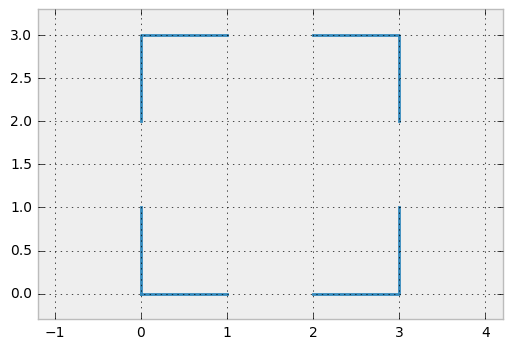

In [8]:
plot_coords(turtle_to_coords('FfF++FfF++FfF++FfF'))

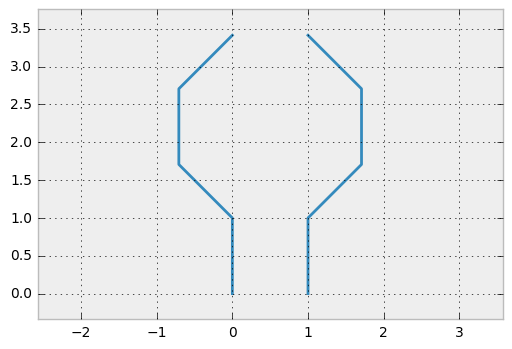

In [9]:
plot_coords(turtle_to_coords('F-F+F+F+f+F+F+F-F'))

Instead of plotting the coordinates generated, we can also list them. This is especially useful when the results don't look like what you expect. Here's a simple function to print out a list of coordinates, indicating gaps in the path.

In [10]:
from math import isnan
def print_coords(coords):
    for (x, y) in coords:
        if isnan(x):
            print('<gap>')
        else:
            print('({:.2f}, {:.2f})'.format(x, y))

print_coords(turtle_to_coords('F-F+F+F+f+F+F+F-F'))

(0.00, 0.00)
(-0.00, 1.00)
(-0.71, 1.71)
(-0.71, 2.71)
(-0.00, 3.41)
<gap>
(1.00, 3.41)
(1.71, 2.71)
(1.71, 1.71)
(1.00, 1.00)
(1.00, -0.00)


Note that each "turn" instruction changed the angle by 45 degres. I made this the default, but `turtle_to_coords` can optionally take a second argument called `turn_amount`. This gives us a way to specify the amount to turn the turtle by on a rotation command (`'-'` or `'+'`). Observe how different values can result in very different looking plots, even for the same turtle program. Compare the following to the above plot of the same program with a different angle.

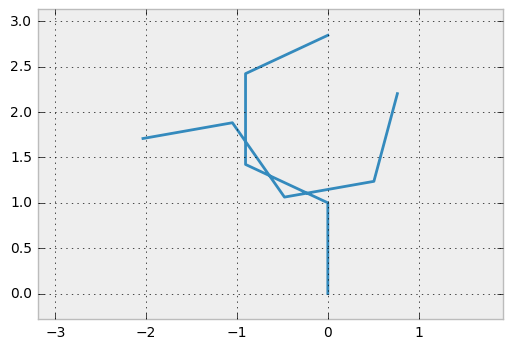

In [11]:
plot_coords(turtle_to_coords('F-F+F+F+f+F+F+F-F', 65))

## String Rewriting



One of the cool things about turtle graphics is that it gives us a way to represent a path as a string. This means that we can operate on it using tools for manipulating strings, and then plot the results.

One simple string transformation is to take an initial string (which we call the axiom) and one or more transformation rules. Each transformation rule specifies a character and a string. Each time the rule's character appears in the axiom, it is replaced with the rule's string. Characters in the axiom which do not have a rule are left alone.

In Python, we can represent the transformation rules as a dictionary. Each transformation rule is represented as an entry with the character as key and replacement string as value.

For example, the rules
- `a → aba`
- `c → bb`

Are represented in Python as `{'a': 'aba', 'c': 'bb'}`. With this representation, the transformation function becomes very simple:

In [12]:
def transform_sequence(sequence, transformations):
    return ''.join(transformations.get(c, c) for c in sequence)

transform_sequence('acab', {'a': 'aba', 'c': 'bb'})

'ababbabab'

Here's one of the plots from the last section, this time written with string replacement.

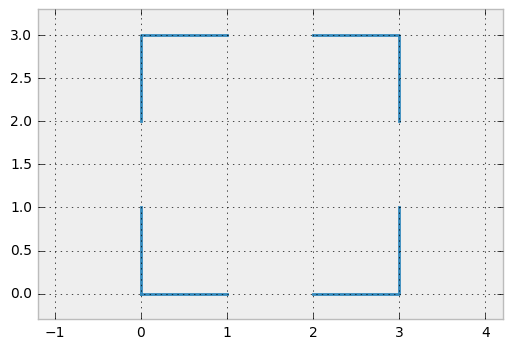

In [13]:
plot_coords(turtle_to_coords(transform_sequence('FFFF', {'F': 'FfF++'})))

Transformations become more interesting when we apply them multiple times. We can take the output of the transformation, then feed it back into the transformation and run it again!

In [14]:
def transform_multiple(sequence, transformations, iterations):
    for _ in range(iterations):
        sequence = transform_sequence(sequence, transformations)
    return sequence

print('0:', transform_multiple('abba', {'b': 'bab'}, 0))
print('1:', transform_multiple('abba', {'b': 'bab'}, 1))
print('2:', transform_multiple('abba', {'b': 'bab'}, 2))

0: abba
1: ababbaba
2: ababababbabababa


Using this method we can create complex images starting with very simple inputs:

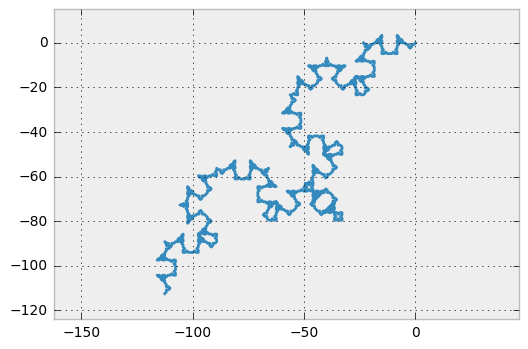

In [15]:
plot_coords(turtle_to_coords(transform_multiple('F', {'F': '+F+F--F+F'}, 5)))

We can also use this to draw a [Hilbert curve](http://mathworld.wolfram.com/HilbertCurve.html):

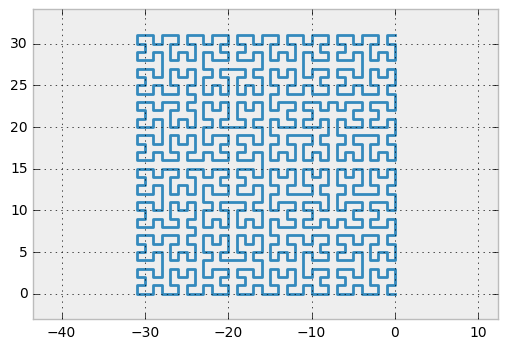

In [16]:
plot_coords(turtle_to_coords(transform_multiple('L', {
    'L': '-RF+LFL+FR-',
    'R': '+LF-RFR-FL+'
}, 5), 90))

## Branching Turtle Graphics

There's one more piece to do before we can draw tree-like structures. So far we've drawn continuous paths. It turns out that it's hard to represent the sort of branching that a tree does with a continuous path.

In order to represent tree-like branching, I'll add two new turtle commands: `'['` and `']'`. One way to think of these commands is that they give our simulated turtle a sense of memory. The `'['` command tells the turtle to stay still but remember its current location (including the angle). The `']'` command tells it to go to the last remembered location. Once the turtle goes back to a remembered location it promptly forgets about it, so then the next time `']'` is called it goes to the last remembered location *before that*. A consequence of this "forgetting" is that the each `']'` must match up with a prior `'['`, otherwise you are essentially asking the turtle to return to more positions than you told it to remember!

In [17]:
def branching_turtle_to_coords(turtle_program, turn_amount=45):
    saved_states = list()
    state = (0, 0, 90)
    yield (0, 0)

    for command in turtle_program:
        x, y, angle = state

        if command.lower() in 'abcdefghij':        # Move forward (matches a-j and A-J)
            state = (x - cos(angle * DEGREES_TO_RADIANS),
                     y + sin(angle * DEGREES_TO_RADIANS),
                     angle)
            
            if command.islower():                  # Add a break in the line if command matches a-j
                yield (float('nan'), float('nan'))

            yield (state[0], state[1])

        elif command == '+':                       # Turn clockwise
            state = (x, y, angle + turn_amount)

        elif command == '-':                       # Turn counterclockwise
            state = (x, y, angle - turn_amount)

        elif command == '[':                       # Remember current state
            saved_states.append(state)

        elif command == ']':                       # Return to previous state
            state = saved_states.pop()
            yield (float('nan'), float('nan'))
            x, y, _ = state
            yield (x, y)

        # Note: We silently ignore unknown commands

Aside from the `'['` and `']'` commands, and the new `saved_states` variable, this looks a lot like `turtle_to_coords`. One other difference I should mention is that now any uppercase letter from `A` to `J` will move foward and draw a line, and any lowercase letter `a` to `j` will move forward without drawing. This opens up more possibilities when it comes to string rewriting.

To understand what's going on, consider the following (branching) turtle program:

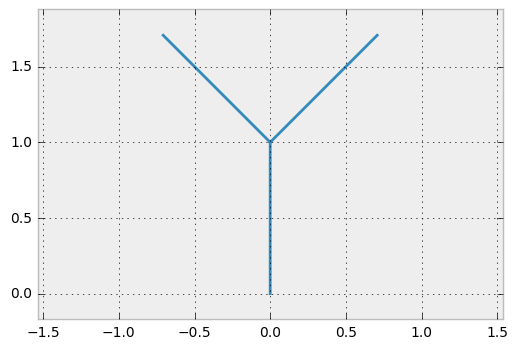

In [18]:
plot_coords(branching_turtle_to_coords('F[-F]+F', 45))

Recall that the turtle starts at `(0, 0)` facing up. The first `F` moves the turtle to `(0, 1)`, still pointing up. Then the `'['` command tells the turtle to **remember its current position**. The turtle then does a counter-clockwise rotation, goes forward, and *resumes the remembered location*. Then it rotates clockwise (remember, when it returned to its remembered position at `(0, 1)` it returned to the angle it remembered as well), and goes forward again.

Now that we have everything we need for an L-system, let's wrap it up in a function called `l_plot` that runs through all the steps in generating a graphic. To review, that's:
1. Iteratively apply the string rewriting transformations a given number of times.
2. Convert the turtle program to a list of coordinates.
3. Draw the result.

In [19]:
def l_plot(axiom, transformations, iterations=0, angle=45):
    turtle_program = transform_multiple(axiom, transformations, iterations)
    coords = branching_turtle_to_coords(turtle_program, angle)
    plot_coords(coords, bare_plot=True) # bare_plot removes the axis labels

Here's a plot based on the branching above, iterated several times:

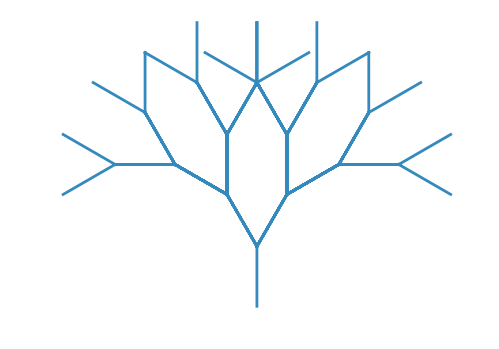

In [20]:
l_plot('F', {'F': 'F[-F][+F]'}, 4, 30)

It's almost starting to look like a tree! The symmetry is a bit sterile though, let's do something a bit asymmetric.

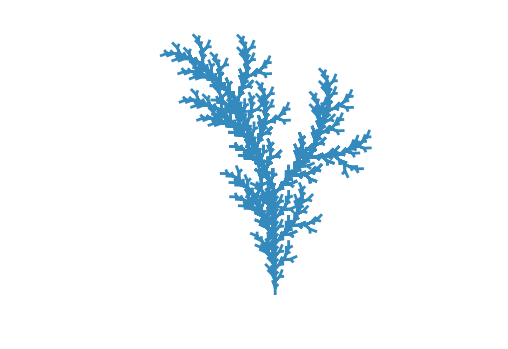

In [21]:
l_plot('F', {'F': 'FF[++F][-FF]'}, 5, 22)

It looks more like a bush to me, but we're on the right track. A technique to make things look more tree-like is to make the lines closer to the root "longer". One way to do this is to use a rule like `F → FF`

This has the effect of making lines that appear *earlier* get *longer*. To see what I mean, look at the behavior of the following rule over several iterations:

In [22]:
for i in range(5):
    print('{}: '.format(i),
          transform_multiple('A', {'A': 'F+A'}, i))

0:  A
1:  F+A
2:  F+F+A
3:  F+F+F+A
4:  F+F+F+F+A


Now, look at the same rule when I add the rule `F → FF`:

In [23]:
for i in range(5):
    print('{}: '.format(i),
          transform_multiple('A', {'A': 'F+A', 'F': 'FF'}, i))

0:  A
1:  F+A
2:  FF+F+A
3:  FFFF+FF+F+A
4:  FFFFFFFF+FFFF+FF+F+A


This is somewhat akin to cell division in nature: the A "cell" divides into two cells, F and A, while the F cell divides into two F cells. Applying this to a tree, we start to get something that looks realistic:

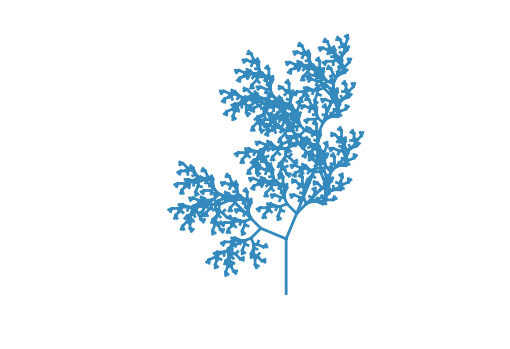

In [24]:
l_plot('A', {'F': 'FF', 'A': 'F[+AF-[A]--A][---A]'}, 5, 22.5)

## What Next

I encourage you to use the code provided in this notebook to create L-systems of your own. If you're interested in learning more, I recommend the book *The Algorithmic Beauty of Plants*, as well as the other resources listed below.

- [Algorithmic Beauty of Plants](http://algorithmicbotany.org/papers/#abop)
- [MathWorld: Lindenmayer System](http://mathworld.wolfram.com/LindenmayerSystem.html)
- [Wikipedia: L-system](https://en.wikipedia.org/wiki/L-system)